# Experimenting with least squares and its variants

In [33]:
%matplotlib inline

from sklearn import datasets
from scipy.optimize import fmin_bfgs
import numpy as np
from numpy.linalg import norm
from numpy.linalg import inv

## Data preparation

In [34]:
boston = datasets.load_boston()
data = np.array(boston.data)
data.shape

(506, 13)

The boston dataset is one of the standard regression problems used to experiment with learning algorithms. Below you can find the dataset description

In [3]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

First step to apply the formulae we learnt during the lectures is to rewrite the dataset in homogeneous coordinates (i.e., we append a column of 1 to the matrix containing the examples):

In [35]:
t = np.ones(len(data)).reshape(len(data),1)
data = np.append(data, t, 1)
target = np.array(boston.target)
data.shape

(506, 14)

We now divide the data into a training set $X$ and a test set $X_\textrm{test}$.

In [36]:
X,y = data[0:400,:], target[0:400]
X_test, y_test = data[400:,:], target[400:]

# Exercise

1. Calculate the least square solution (to the regression problem outlined above) and evaluate its performances on the training set and on the test set.
1. Calculate the ridge regression solution (set lambda to 0.01) and evaluate its performances on the training set and on test set.
1. Calculate the lasso regression solution and evaluate its performances on the training set and on the test set.

## Notes

- Here it follows a list of functions you may want to use (the required packages are already imported at the beginning of this notebook) along with a very brief explanation of their purpose (`help(nomefun)` will provide you more information about function `nomefun`):
    - `transpose`: matrix transposition (e.g., `transpose(X)`)
    - `dot`: matrix multiplication (e.g., `X.dot(X2)`) 
    - `inv`: matrix inversion (e.g., `inv(X)`)
- to solve the lasso problem you will need to perform a numerical minimization of the associated loss function (as you know, a closed form solution does not exist). There are many numerical optimization algorithms available in the scipy package. My suggestion is to use `fmin_bfgs`. Here it follows an example of how to use it:
    ```python
        def f(w):
            return w[0]**2 + w[1]**2 + w[0] + w[1]
        
        w = fmin_bfgs(f, [0,0])
    ```
    note that the function may (and should) reference your data variables (i.e., $X$ and $y$).
- to evaluate the performances of your solutions use the $S$ statistic:
    $$
        S =  \sqrt{ \frac{1}{n} \sum_{i=1}^n (y_i' - y_i)^2 }
    $$
    where $y'_i$ is your model prediction for the i-th example, and $n$ is the number of examples.

# Exercise \#1: Least squares for Linear Regression

From the theory, we know that the optimal solution $w^*$ to the least squares that minimize the residuals sum have a closed form:
$$ w^* = X^+y =(X^TX)^{-1}X^Ty$$

In [6]:
w = np.linalg.pinv(X).dot(y)
print("Weights:\n{}".format(w))

Weights:
[-1.91246374e-01  4.42289967e-02  5.52207977e-02  1.71631351e+00
 -1.49957220e+01  4.88773025e+00  2.60921031e-03 -1.29480799e+00
  4.84787214e-01 -1.54006673e-02 -8.08795026e-01 -1.29230427e-03
 -5.17953791e-01  2.86725996e+01]


To check if our results are consistent with more robust implementation, we compare our "custom" implementation with the one provided by sci-kit learn package

In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(copy_X=False)
reg.fit(X,y) # fit sklearn model to data

custom_predictions = X_test.dot(w)
sklearn_predictions = reg.predict(X_test)

msg = "Custom predictions and sklearn predictions are {}!"
print(msg.format("equal")) if np.allclose(sklearn_predictions, custom_predictions) else print(msg.format("different"))

Custom predictions and sklearn predictions are equal!


### Evaluate model performance
To evaluate the model performance, we compute the error on the *test set* using the RMSE metric.
Since RMSE is expressed in the same unit scale of the target variable, to asses qualitatively the goodness of RMSE we check the regression variable range ($y_{max}-y_{min}$)

In [10]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test,custom_predictions,squared=False)
print("Model's RMSE: {:.3f}\nTarget variable scale: {}".format(rmse, np.ptp(target)))


Model's RMSE: 6.156
Target variable scale: 45.0


## Exercise \#2: Use Ridge Regularization
To make our model more robust to noise error into the data, we can apply the most basic regularization's technique: the *ridge regularization* method (aka *Tikhonov* regularization). In layman's terms this method apply a simple **constraint** on the model' weights vector constraining it's squared norm $||\cdot||_2$. The regularization contribution can be tweaked by the *shrinkage parameter* $\lambda$. The solution $w^*$ to the optimization problem could be rewrited as:

$$ w^* = \operatorname*{argmin}_w || y-Xw||^2_2 + \lambda ||w||_2^2 $$

Also in this case we have a closed form solution:
$$ w^* =(X^TX + \lambda I)^{-1}X^Ty$$


In [41]:
shrinkage =0.01 # tweak shrinkage parameter

def custom_ridge(X,y,shrinkage):
    square_matrix = np.matmul(X.T,X)
    I = np.identity(square_matrix.shape[0]) * shrinkage
    inverse = np.linalg.inv(square_matrix + I)

    w_ridge = np.matmul(inverse,X.T).dot(y)
    
    return w_ridge
w_ridge = custom_ridge(X,y,shrinkage)

print("Weights:\n{}".format(w_ridge))

Weights:
[-1.91174244e-01  4.42530512e-02  5.46287404e-02  1.71529415e+00
 -1.48622418e+01  4.88842996e+00  2.50455102e-03 -1.29305879e+00
  4.84462126e-01 -1.54188414e-02 -8.07341324e-01 -1.24926078e-03
 -5.18127190e-01  0.00000000e+00]


### Compare with sci-kit learn implementation

In [42]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=shrinkage,copy_X=False)
ridge_reg.fit(X,y) # fit sklearn model to data

msg = "Custom  and sklearn regression coefficients are {}!"
print(msg.format("equal")) if np.allclose(w_ridge, ridge_reg.coef_) else print(msg.format("different"))

Custom  and sklearn regression coefficients are equal!


### Evaluate model performance

In [43]:
predictions = X_test.dot(w_ridge)

rmse = mean_squared_error(y_test,predictions,squared=False)
print("Model's RMSE: {:.3f}\nTarget variable scale: {}".format(rmse, np.ptp(target)))

Model's RMSE: 25.490
Target variable scale: 45.0


## Shrinkage effect visualization
To asses how weights changed when $\lambda$ gets higher value, we train a different model with increasing shrinkage coefficient and than plot a line for each weight

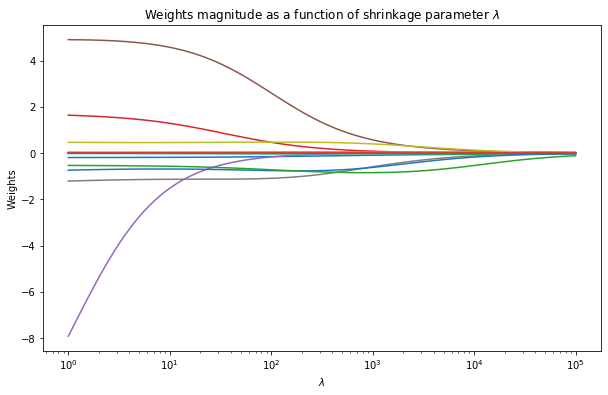

In [12]:
import matplotlib.pyplot as plt

shrinkages = np.logspace(0,5,100)

coeffs=[]
for s in shrinkages:
    w = custom_ridge(X,y,s)
    coeffs.append(w)
    
    
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(shrinkages,coeffs)

ax.set_xscale('log')
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Weights")
ax.set_title("Weights magnitude as a function of shrinkage parameter $\lambda$");

## Exercise \#3: Use LASSO Regularization
Lasso regualarization methods is similar to the previus one, the main difference is that the constraint is expressed in $||\cdot||_1$ norm. The solution $w^*$ to the optimization problem could be rewritten as:
$$
w^* = \operatorname*{minimize}_w ||y-Xw||^2_2 + \lambda||w||_1
$$



Unfortunately there's **no closed form solution**, so we must use an iterative optimization method to minimize the loss function

In [18]:
import scipy.optimize as opt

In [19]:
t = np.ones(len(data)).reshape(len(data),1)
data = np.append(data, t, 1)
target = np.array(boston.target)
data.shape

X,y = data[0:400,:], target[0:400]
X_test, y_test = data[400:,:], target[400:]

In [31]:
def lasso_loss(w,X,y,shrinkage):
    pred = X.dot(w) # get prediction (y'=X*w)
    ssd = np.sum((y-pred)**2) # sum of squared differences
    
    return (1/(2*X.shape[0])) * ssd + shrinkage * np.linalg.norm(w,ord=1)

def lasso_fit(X,y,shrinkage):
    
    w_init = np.zeros(X.shape[1])
    res = opt.minimize(lasso_loss, x0=w_init, args=(X,y,shrinkage),
                       method='Nelder-Mead',options={'maxiter':100000,'disp':True})
    return res['x']

In [27]:
w_lasso = lasso_fit(X,y,shrinkage=2.5)

Optimization terminated successfully.
         Current function value: 226333.051130
         Iterations: 4479
         Function evaluations: 5881


In [28]:
w_lasso

array([ 0.56059039, -0.00959534, -0.42714985,  0.3716057 ,  2.71368608,
        5.60895417, -0.05307812, -2.62471334, -1.70681963,  0.06249757,
       -0.63549734,  0.04287858, -0.69142989, -5.43038798,  2.03828983])

In [29]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=2.5)
lasso.fit(X,y)

Lasso(alpha=2.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [30]:
lasso.coef_

array([-0.        ,  0.03686395, -0.        ,  0.        ,  0.        ,
        0.        ,  0.059244  , -0.06243391,  0.20312011, -0.01205994,
       -0.47308683,  0.01031908, -0.90971843,  0.        ,  0.        ])